Code source: Tutorial by Giorgio Domenichini

CPHF: CPHF (Coupled Perturbed Hartree-Fock) alchemical derivatives are quantities used in computational chemistry and quantum chemistry to calculate the change in molecular properties with respect to changes in the nuclear positions or atomic charges.

Gaussian-type orbitals (GTOs) are mathematical functions commonly used to represent atomic orbitals in quantum chemistry calculations. They are named after the Gaussian distribution function that describes their radial behavior. GTOs provide a flexible and efficient basis for approximating the wavefunctions of electrons in molecules.

Basis sets are a set of mathematical functions that are used to approximate the wave functions of electrons in molecules

In [1]:
import sys
sys.path.append('../APDFT')
sys.path.append('../Data')

In [46]:
from pyscf import gto,scf
import numpy as np
import pandas as pd
import pyscf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import basis_set_exchange as bse
from FcMole import FcM, FcM_like
import os
import ast
from IPython.display import display

%load_ext autoreload
%autoreload 2
from AP_class import APDFT_perturbator as AP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# mol_NN = gto.M(atom= "N 0 0 0; N 0 0 2.1",
#                unit="Bohr",
#                basis="unc-cc-pvdz")

# mol_NN_pcX2=gto.M(atom= "N 0 0 0; N 0 0 2.1",
#                   unit="Bohr",
#                   basis=bse.get_basis('pcX-2',fmt="nwchem",elements=[6,7,8]))

In [ ]:
# mf = scf.RKS(mol_NN) # create a restricted Kohn-Sham (RKS) mean-field object used for electronic structure calculation
# mf.xc = "PBE0" # sets the exchange-correlation (XC) functional to "PBE0"
# energy = mf.scf()

In [ ]:
# ap_nn=AP(mf,sites=[0,1]) # prepare to perform alchemical perturbing DFT calculations
# H = ap_nn.build_hessian()
# print(H)

## Calculating Hessian ##

In [3]:
# create the NN molecule
mol_NN = gto.M(atom= "N 0 0 0; N 0 0 2.1",
               unit="Bohr",
               basis="unc-cc-pvdz")

In [4]:
def get_energy_DFT(mol):
    """ 
    Compute the total energy of a given molecule, in a.u., using DFT calculation

    Args:
        mol (pyscf.gto.mole.Mole): a PySCF Gaussian-type orbital (GTO) molecule object 
    
    Returns:
        mf (pyscf.dft.rks.RKS): the mean-field object for the molecule (used for other DFT related calculations) 
        energy (float): the total energy of the molecule
    """

    mf = scf.RKS(mol) # create a restricted Kohn-Sham (RKS) mean-field object used for electronic structure calculation
    mf.xc = "PBE0" # sets the exchange-correlation (XC) functional to "PBE0"
    energy = mf.scf() # performs self-consistent field (SCF) calculations

    return energy, mf

In [5]:
def get_energy_HF(mol):
    """ 
    Compute the total energy of a given molecule, in a.u., using DFT calculation

    Args:
        mol (pyscf.gto.mole.Mole): a PySCF Gaussian-type orbital (GTO) molecule object 
    
    Returns:
        mf (pyscf.dft.rks.RKS): the mean-field object for the molecule (used for other DFT related calculations) 
        energy (float): the total energy of the molecule
    """

    mf = scf.RHF(mol) # create a restricted Hartree-Fock (RHF) mean-field object used for electronic structure calculation
    energy = mf.scf() # performs self-consistent field (SCF) calculations

    return energy, mf

In [6]:
# Calculate the energy and the Hessian

energy_nn, mf_nn = get_energy_DFT(mol_NN)
ap_nn=AP(mf_nn, sites=[0,1]) # prepare to perform alchemical perturbing DFT calculations
H = ap_nn.build_hessian()
print(H)

converged SCF energy = -109.415080022349
[[-3.26630067  0.50149887]
 [ 0.50149887 -3.26630067]]


In [7]:
# compute the diagnalization matrix (of eigenvectors) Q

epsilon, Q = np.linalg.eig(H)
Q_inv = np.linalg.inv(Q)
print(Q_inv)
print(epsilon)

[[-0.70710678  0.70710678]
 [-0.70710678 -0.70710678]]
[-3.76779954 -2.76480179]


## Get Training Data ##

### Loading Data ###

In [21]:
element_dict = {0: None, 1: 'H', 2: 'He',
                3: 'Li', 4: 'Be', 5: 'B', 6: 'C', 7: 'N', 8: 'O', 9: 'F', 10: 'Ne',
                11: 'Na', 12: 'Mg', 13: 'Al', 14: 'Si', 15: 'P', 16: 'S', 17: 'Cl', 18: 'Ar',
                19: 'K', 20: 'Ca'}

In [64]:
def generate_diatomic_data():
    """ 
    Generate diatomic energy data from scratch using DFT calculation.
    The generated DataFrame will have the following columns: charge, net charge, element, dx, energy

    Args: None
    
    Returns:
        diatomic_data (pandas DataFrame): DataFrame containing the energy of each molecule, along with other information
    """
    
    # create an empty DataFrame with 3 columns: charge, element, energy
    columns = ['charge', 'net charge', 'element', 'dx', 'energy']
    diatomic_data = pd.DataFrame(columns=columns)

    # generate all charge combinations (fractional included) for 14-electron diatomic molecules
    # net charges include 0, 1+, 2+, 1-
    neutral_values = np.arange(0.1, 14, 0.1)
    neutral_charges = np.column_stack((neutral_values, 14 - neutral_values))
    neutral_charges = np.round(charges, decimals = 1)
    
    plus_one_values = np.arange(0.1, 15, 0.1)
    plus_one_charges = np.column_stack((plus_one_values, 15 - plus_one_values)) 
    plus_one_charges = np.round(charges, decimals = 1)
    
    plus_two_values = np.arange(0.1, 16, 0.1)
    plus_two_charges = np.column_stack((plus_two_values, 16 - plus_two_values)) 
    plus_two_charges = np.round(plus_two_charges, decimals = 1)

    minus_one_values = np.arange(0.1, 13, 0.1)
    minus_one_charges = np.column_stack((minus_one_values, 16 - minus_one_values)) 
    minus_one_charges = np.round(minus_one_charges, decimals = 1)  
    
    charges = np.vstack((neutral_charges, plus_one_charges, plus_two_charges, minus_one_charges))

    diatomic_data['charge'] = charges.tolist()
    diatomic_data['net charge'] = diatomic_data['charge'].apply(lambda x: sum(x) - 14)
 
    # compute the energy for each molecule
    for index, row in diatomic_data.iterrows():
        charges = row['charge']

        # compute the dx value (i.e. charge perturbation with respect to NN)
        dx = [charges[0] - 7, charges[1] - 7]
        dx = np.round(dx, decimals = 1).tolist()
        diatomic_data.at[index, 'dx'] = dx
        
        # print current process
        if (index % 10 == 0):
            print(f"dx: {dx}")

        # create a new molecule from dx and calculate its energy
        target_mol = FcM_like(mol_NN, fcs=dx) # create a new molecule
        target_mf = scf.RKS(target_mol) 
        target_mf.xc = "PBE0"
        target_mf.verbose = False
        target_energy = target_mf.scf(dm0=target_mf.init_guess_by_1e())
        diatomic_data.at[index, 'energy'] = target_energy 
        
        # if the charge take integer values, note down the corresponding molecule
        if all(charge.is_integer() for charge in charges): 
            int_charges = [int(charge) for charge in charges] 
            diatomic_data.at[index, 'element'] = [element_dict[charge] for charge in int_charges]

        return diatomic_data 

In [75]:
def load_diatomic_data():
    """ 
    Get the diatomic molecule data and store them in pandas dataframe
    If there exist a file with pre-calculated diatomic energy, directly open it.
    If not, calculate the energy for each molecule and store the data as a separate file

    Args: None
    
    Returns:
        diatomic_data (pandas DataFrame): DataFrame containing the energy of each molecule, along with other information
    """
    
    if os.path.isfile('../Data/extended_diatomic_data_w_energy.csv'):
        diatomic_data = pd.read_csv('../Data/extended_diatomic_data_w_energy.csv', sep='\t', index_col=0, header = 0)
        diatomic_data['charge'] = diatomic_data['charge'].apply(lambda x: ast.literal_eval(x))
        diatomic_data['dx'] = diatomic_data['dx'].apply(lambda x: ast.literal_eval(x))
    else:
        diatomic_data = generate_diatomic_data()
    return diatomic_data

In [76]:
diatomic_data = load_diatomic_data()
display(diatomic_data)

,charge,net charge,element,dx,energy
0,"[0.1, 13.9]",0.0,NaN,"[-6.9, 6.9]",-282.512821
1,"[0.2, 13.8]",0.0,NaN,"[-6.8, 6.8]",-277.699197
2,"[0.3, 13.7]",0.0,NaN,"[-6.7, 6.7]",-273.041699
3,"[0.4, 13.6]",0.0,NaN,"[-6.6, 6.6]",-268.366512
4,"[0.5, 13.5]",0.0,NaN,"[-6.5, 6.5]",-263.747315
...,...,...,...,...,...
571,"[12.5, 0.5]",-1.0,NaN,"[5.5, -6.5]",-219.350627
572,"[12.6, 0.4]",-1.0,NaN,"[5.6, -6.6]",-223.528722
573,"[12.7, 0.3]",-1.0,NaN,"[5.7, -6.7]",-227.761828
574,"[12.8, 0.2]",-1.0,NaN,"[5.8, -6.8]",-232.049431


### Visualizing Data ###

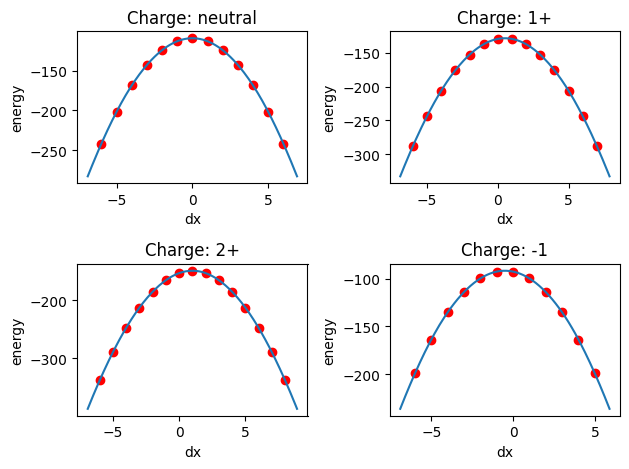

In [81]:
# Plot the energy curve

# Load the data from DataFrame
x1 = diatomic_data.loc[diatomic_data['net charge'] == 0, 'dx'].apply(lambda x: x[0])
y1 = diatomic_data.loc[diatomic_data['net charge'] == 0, 'energy']

x2 = diatomic_data.loc[diatomic_data['net charge'] == 1, 'dx'].apply(lambda x: x[0])
y2 = diatomic_data.loc[diatomic_data['net charge'] == 1, 'energy']

x3 = diatomic_data.loc[diatomic_data['net charge'] == 2, 'dx'].apply(lambda x: x[0])
y3 = diatomic_data.loc[diatomic_data['net charge'] == 2, 'energy']

x4 = diatomic_data.loc[diatomic_data['net charge'] == -1, 'dx'].apply(lambda x: x[0])
y4 = diatomic_data.loc[diatomic_data['net charge'] == -1, 'energy']

# Generate integer data for marker
integer_x1 = x1[x1.astype(int) == x1]
integer_y1 = y1[x1.astype(int) == x1]

integer_x2 = x2[x2.astype(int) == x2]
integer_y2 = y2[x2.astype(int) == x2]

integer_x3 = x3[x3.astype(int) == x3]
integer_y3 = y3[x3.astype(int) == x3]

integer_x4 = x4[x4.astype(int) == x4]
integer_y4 = y4[x4.astype(int) == x4]

# Create a subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2)

# Plot the data
axes[0, 0].plot(x1, y1)
axes[0, 0].scatter(integer_x1, integer_y1, color='red', marker='o')
axes[0, 0].set_title('Charge: neutral')

axes[0, 1].plot(x2, y2)
axes[0, 1].scatter(integer_x2, integer_y2, color='red', marker='o')
axes[0, 1].set_title('Charge: 1+')

axes[1, 0].plot(x3, y3)
axes[1, 0].scatter(integer_x3, integer_y3, color='red', marker='o')
axes[1, 0].set_title('Charge: 2+')

axes[1, 1].plot(x4, y4)
axes[1, 1].scatter(integer_x4, integer_y4, color='red', marker='o')
axes[1, 1].set_title('Charge: -1')

# Add axis title
for ax in axes.flat:
    ax.set_xlabel('dx')
    ax.set_ylabel('energy')

# show graph
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

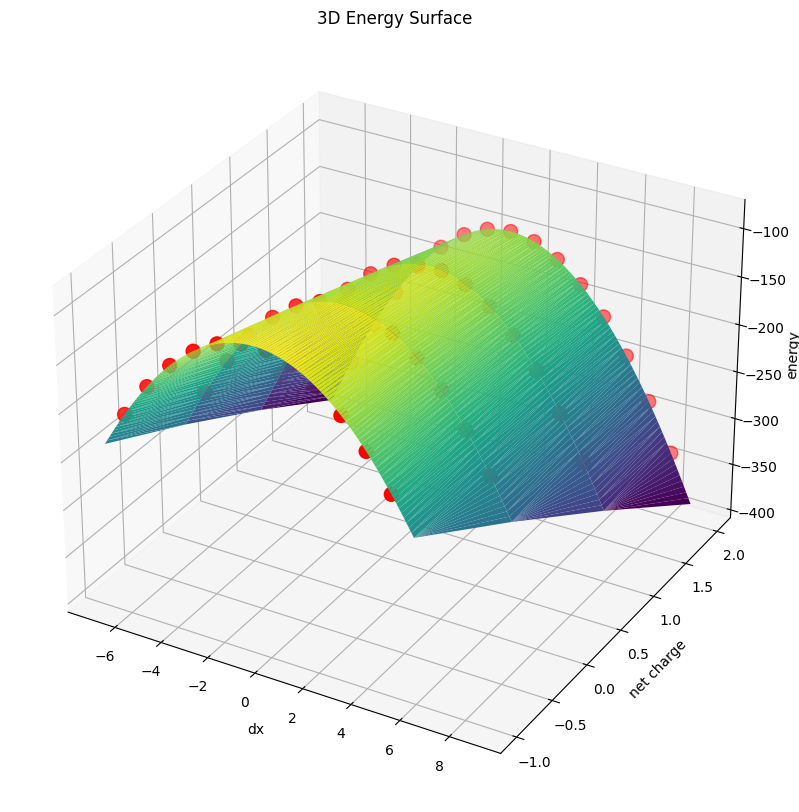

In [87]:
# Graph the energy data in a 3D surface plot

# Load data from dataframe
x1 = pd.to_numeric(diatomic_data['dx'].apply(lambda x: x[0]))
x2 = pd.to_numeric(diatomic_data['net charge'])
y = pd.to_numeric(diatomic_data['energy'])

# Create integer valued data
integer_x1 = x1[x1.astype(int) == x1]
integer_x2 = x2[x1.astype(int) == x1]
integer_y = y[x1.astype(int) == x1]

# Plot the data
fig = plt.figure()
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(integer_x1, integer_x2, integer_y, c='r', marker='o', s=100)
ax.plot_trisurf(x1, x2, y, cmap='viridis')

# Set labels and title
ax.set_xlabel('dx')
ax.set_ylabel('net charge')
ax.set_zlabel('energy')
ax.set_title('3D Energy Surface')

plt.show()

### Compute ANM coordinates ###

In [88]:
# express each molecule using the ANM basis
# c = Q_inv @ dx

dx_array = np.array(diatomic_data['dx'].tolist())

c_array = (Q_inv @ dx_array.T).T

diatomic_data['c'] = c_array.tolist()
diatomic_data['coord0'] = diatomic_data['c'].apply(lambda x: x[0])
diatomic_data['coord1'] = diatomic_data['c'].apply(lambda x: x[1])

column_order = ['charge', 'net charge', 'element', 'dx', 'c', 'coord0', 'coord1', 'energy']
diatomic_data = diatomic_data.reindex(columns=column_order)

display(diatomic_data)

,charge,net charge,element,dx,c,coord0,coord1,energy
0,"[0.1, 13.9]",0.0,NaN,"[-6.9, 6.9]","[9.758073580374358, -3.773515530510749e-11]",9.758074,-3.773516e-11,-282.512821
1,"[0.2, 13.8]",0.0,NaN,"[-6.8, 6.8]","[9.616652224137047, -3.7188526550341335e-11]",9.616652,-3.718853e-11,-277.699197
2,"[0.3, 13.7]",0.0,NaN,"[-6.7, 6.7]","[9.475230867899738, -3.664163765413896e-11]",9.475231,-3.664164e-11,-273.041699
3,"[0.4, 13.6]",0.0,NaN,"[-6.6, 6.6]","[9.333809511662427, -3.6094120720953104e-11]",9.333810,-3.609412e-11,-268.366512
4,"[0.5, 13.5]",0.0,NaN,"[-6.5, 6.5]","[9.192388155425117, -3.5547231824750725e-11]",9.192388,-3.554723e-11,-263.747315
...,...,...,...,...,...,...,...,...
571,"[12.5, 0.5]",-1.0,NaN,"[5.5, -6.5]","[-8.485281374235836, 0.7071067812193604]",-8.485281,7.071068e-01,-219.350627
572,"[12.6, 0.4]",-1.0,NaN,"[5.6, -6.6]","[-8.626702730473145, 0.7071067812199073]",-8.626703,7.071068e-01,-223.528722
573,"[12.7, 0.3]",-1.0,NaN,"[5.7, -6.7]","[-8.768124086710456, 0.707106781220454]",-8.768124,7.071068e-01,-227.761828
574,"[12.8, 0.2]",-1.0,NaN,"[5.8, -6.8]","[-8.909545442947765, 0.7071067812210008]",-8.909545,7.071068e-01,-232.049431


In [95]:
print(diatomic_data['energy'].dtype)

float64


## Machine Learning ##

In [90]:
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import warnings

In [113]:
X = diatomic_data[['coord0', 'coord1']]
y = diatomic_data['energy']

In [100]:
print(y.dtype)
print(X['coord0'].dtype)
print(X['coord1'].dtype)

float64
float64
float64


### Gaussian Kernel ###

In [119]:
# Gaussian kernel
params = {'alpha': 2.45e-11, 'gamma': 0.005, 'kernel': 'rbf'}
gaussian_KRR = KernelRidge(**params)

# Define the scoring metric
scoring_metric = make_scorer(mean_absolute_error)

# Perform cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = cross_val_score(gaussian_KRR, X, y, scoring=scoring_metric, cv=k_fold)

# Calculate the average error across all folds
avg_mae = mae_scores.mean()

# Print the mean squared error for each fold
for fold, mae in enumerate(mae_scores):
    print(f"Fold {fold+1}: MAE = {mae}")

# Print the average mean squared error
print(f"Average MAE across all folds: {avg_mae}")

Fold 1: MAE = 0.01638685011986153
Fold 2: MAE = 0.015169391554751206
Fold 3: MAE = 0.018097545219468776
Fold 4: MAE = 0.01466698523817503
Fold 5: MAE = 0.016964630273716474
Average MAE across all folds: 0.0162570804811946


### Polynomial Kernel ###

In [121]:
# Polynomial Kernel

params = {'alpha': 1.2742749857031348e-07, 'coef0': 188.0, 'degree': 4, 'kernel': 'poly'}
poly_KRR = KernelRidge(**params)

# Define the scoring metric
scoring_metric = make_scorer(mean_absolute_error)

# Perform cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = cross_val_score(poly_KRR, X, y, scoring=scoring_metric, cv=k_fold)

# Calculate the average error across all folds
avg_mae = mae_scores.mean()

# Print the mean squared error for each fold
for fold, mae in enumerate(mae_scores):
    print(f"Fold {fold+1}: MAE = {mae}")

# Print the average mean squared error
print(f"Average MAE across all folds: {avg_mae}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Fold 1: MAE = 0.14528862593393435
Fold 2: MAE = 0.14730858427542678
Fold 3: MAE = 0.15178160761155787
Fold 4: MAE = 0.1445458917880985
Fold 5: MAE = 0.13773895847576204
Average MAE across all folds: 0.14533273361695592


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


### Ridge Regression ###

In [118]:
ridge_regression = Ridge(alpha=0.01)

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = cross_val_score(ridge_regression, X, y, scoring='neg_mean_squared_error', cv=k_fold)
mse_scores = -mse_scores  # Convert negative MSE scores to positive

# Calculate the average error across all folds
avg_mse = mse_scores.mean()

# Print the mean squared error for each fold
for fold, mse in enumerate(mse_scores):
    print(f"Fold {fold+1}: MSE = {mse}")

# Print the average mean squared error
print(f"Average MSE across all folds: {avg_mse}")

Fold 1: MSE = 3662.619148509864
Fold 2: MSE = 3733.4485384226277
Fold 3: MSE = 3570.2028280543745
Fold 4: MSE = 3930.757341402568
Fold 5: MSE = 3117.562085702004
Average MSE across all folds: 3602.9179884182877


## Hyperparameter Tuning ##

### Gaussian Kernel ###

In [ ]:
# # Grid Search Round 1

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-5), np.log10(100), num=20),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.logspace(np.log10(1e-5), np.log10(100), num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# # Grid Search Round 2

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-7), np.log10(1e-5), num=20),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.logspace(np.log10(0.001), np.log10(0.1), num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# # Grid Search Round 3

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-9), np.log10(1e-7), num=20),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.linspace(0.003, 0.005, num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# # Grid Search Round 4

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-11), np.log10(1e-9), num=20),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.linspace(0.003, 0.005, num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# # Grid Search Round 5

# param_grid = {
#     'alpha': np.linspace(2e-11, 3e-11, num=21),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.linspace(0.003, 0.005, num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

### Polynomial Kernel ###

In [ ]:
# # Hyperparam tuning
# # Grid search round 1

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-5), np.log10(100), num=50),
#     'kernel': ['poly'],  
#     'degree': [1, 2, 3, 4], 
#     'coef0': np.logspace(np.log10(1e-5), np.log10(100), num=50), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# # Hyperparam tuning
# # Grid search round 2

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-6), np.log10(1e-4), num=30),
#     'kernel': ['poly'],  
#     'degree': [2, 3, 4], 
#     'coef0': np.linspace(50, 100, num=51), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# # Hyperparam tuning
# # Grid search round 3

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-8), np.log10(1e-6), num=20),
#     'kernel': ['poly'],  
#     'degree': [4], 
#     'coef0': np.linspace(100, 200, num=51), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
#     grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# # Hyperparam tuning
# # Grid search round 4

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-7), np.log10(1e-6), num=20),
#     'kernel': ['poly'],  
#     'degree': [4], 
#     'coef0': np.linspace(170, 200, num=31), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
#     grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

### Ridge Regression ###

In [ ]:
# # Grid Search
# # Round 1

# ridge_model = Ridge()

# # Define the hyperparameters to tune and their respective values
# param_grid = {
#     'alpha': np.logspace(np.log10(0.0001), np.log10(1000), num=80),  # Regularization strength
#     'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],  # Solver algorithm
# }

# # Perform grid search using cross-validation
# grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X, y)

# # Retrieve the best hyperparameters and the corresponding mean squared error
# best_params = grid_search.best_params_
# best_mse = -grid_search.best_score_

# # Print the best hyperparameters and the corresponding mean squared error
# print("Best Hyperparameters:")
# print(best_params)
# print("Best Mean Squared Error:", best_mse)

## Learning Curve ##

In [ ]:
def evaluate_performance(model, X, y, num_training_sample, num_trials):

    """ 
    Given the number of training samples used, 
    calculate the average and standard deviation of MSE across a certain number of trials.
    For each trial, a specified number of training examples is used to train the model, 
    which is then evaluated on the rest of the data set.

    Args:
        X (ndarray): training data; size (N, m) where N is the number of training examples and m is the number of features
        y (ndarray): target data; size (N, 1)
        num_training_sample (int): the number of samples used for training
        num_trials: the number of trials 
    
    Returns:
        average_error: the average MSE across all trials
        std_dev_error: standard deviation of the error across all trials
    """

    errors = []
    test_size = 1.0 - num_training_sample/X.shape[0]

    for i in range(num_trials):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        error = np.sqrt(mean_squared_error(y_val, y_pred)) # Root mean squared error
        errors.append(error)
    
    average_error = np.mean(errors)
    std_dev_error = np.std(errors)
    return average_error, std_dev_error

### Gaussian Kernel ###

In [ ]:
# Gaussian Kernel

best_params_gaussian_KRR = {'alpha': 2.45e-11, 'gamma': 0.005, 'kernel': 'rbf'}
gaussian_KRR_model = KernelRidge(**best_params_gaussian_KRR)

columns = ['training size', 'average RMSE', 'standard deviation']
model_performance_gaussian_KRR = pd.DataFrame(columns=columns)

training_size = [i for i in range(1, 21)]
num_trials = 20

for num_training_sample in training_size:
    index = num_training_sample - 1
    average_error, std_dev_error = evaluate_performance(gaussian_KRR_model, X, y, num_training_sample, num_trials)
    model_performance_gaussian_KRR.at[index, 'training size'] = num_training_sample
    model_performance_gaussian_KRR.at[index, 'average RMSE'] = average_error
    model_performance_gaussian_KRR.at[index, 'standard deviation'] = std_dev_error/np.sqrt(num_trials)

display(model_performance_gaussian_KRR)

### Polynomial Kernel ###

In [ ]:
best_params_poly_KRR = {'alpha': 1.2742749857031348e-07, 'coef0': 188.0, 'degree': 4, 'kernel': 'poly'}
poly_KRR_model = KernelRidge(**best_params_poly_KRR)

columns = ['training size', 'average RMSE', 'standard deviation']
model_performance_poly_KRR = pd.DataFrame(columns=columns)

training_size = [i for i in range(1, 21)]
num_trials = 20

with warnings.catch_warnings():
    for num_training_sample in training_size:
        warnings.filterwarnings("ignore")
        index = num_training_sample - 1
        average_error, std_dev_error = evaluate_performance(poly_KRR_model, X, y, num_training_sample, num_trials)
        model_performance_poly_KRR.at[index, 'training size'] = num_training_sample
        model_performance_poly_KRR.at[index, 'average RMSE'] = average_error
        model_performance_poly_KRR.at[index, 'standard deviation'] = std_dev_error/np.sqrt(num_trials)

display(model_performance_poly_KRR)

In [ ]:
# # graphing

# graph_x = model_performance['training size']
# graph_y = model_performance['average RMSE']
# graph_error = model_performance['standard deviation']

# # Set figure size
# plt.figure(figsize=(10, 6))

# # Create line plot with error bars
# plt.errorbar(graph_x, graph_y, yerr=graph_error, marker='o', linestyle='-', capsize=4)

# # Set axis labels and title
# plt.xlabel('Training Size')
# plt.ylabel('Average RMSE')
# plt.title('Learning curve for diatomic molecule energy prediction using polynomial KNN')

# plt.xscale('log')
# plt.yscale('log')


# # Save the figure as a PNG image
# plt.savefig('learning_curve_20_points.png', dpi=300)
# plt.show()

In [ ]:
# No error bar
# Set figure size
plt.figure(figsize=(10, 6))

# Load the data
x = model_performance_poly_KRR['training size']
y1 = model_performance_poly_KRR['average RMSE']
y2 = model_performance_gaussian_KRR['average RMSE']

# Plotting
plt.plot(x, y1, label='Polynomial KRR', marker='o', linestyle='-', linewidth=2.5)
plt.plot(x, y2, label='Gaussian KRR', marker='o', linestyle='-', linewidth=2.5)

# Customize the x label
plt.xticks(range(1, 21), rotation=45, ha='center') 
plt.gca().xaxis.set_tick_params(which='both', labelbottom=True)

# Customize the plot
plt.title('Learning curve for diatomic molecule energy prediction')
plt.xlabel('Training Size')
plt.ylabel('Average RMSE [Ha] (log)')
plt.legend()

# Create log scale
plt.xscale('log', base=2)
plt.yscale('log')

# Display the plot
plt.savefig('../Graph/[Diatomic] learning_curve_no_error_bar.png', dpi=300)
plt.show()

In [ ]:
# With error bar
# Set figure size
plt.figure(figsize=(10, 6))

# Load the data
x = model_performance_poly_KRR['training size']
y1 = model_performance_poly_KRR['average RMSE']
y2 = model_performance_gaussian_KRR['average RMSE']
y1_error = model_performance_poly_KRR['standard deviation']
y2_error = model_performance_gaussian_KRR['standard deviation']

# Plotting
plt.errorbar(x, y1, label='Polynomial KRR', yerr=y1_error, marker='o', linestyle='-', capsize=3)
plt.errorbar(x, y2, label='Gaussian KRR', yerr=y2_error, marker='o', linestyle='-', capsize=3)
# plt.plot(x, y1, label='Polynomial KRR', marker='o', linestyle='-', linewidth=2.5)
# plt.plot(x, y2, label='Gaussian KRR', marker='o', linestyle='-', linewidth=2.5)

# Customize the x label
plt.xticks(range(1, 21), rotation=45, ha='center') 
plt.gca().xaxis.set_tick_params(which='both', labelbottom=True)

# Customize the plot
plt.title('Learning curve for diatomic molecule energy prediction')
plt.xlabel('Training Size')
plt.ylabel('Average RMSE [Ha] (log)')
plt.legend()

# Create log scale
plt.xscale('log', base=2)
plt.yscale('log')

# Display the plot
plt.savefig('../Graph/[Diatomic] learning_curve_with_error_bar.png', dpi=300)
plt.show()